<a href="https://colab.research.google.com/github/mella30/Deep-Learning-with-Tensorflow-2/blob/main/Course1-Getting_started_with_TensorFlow_2/week3_Validation_Regularisation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
print(tf.__version__)

2.5.0


# Validation, regularisation and callbacks

 ## Coding tutorials
 #### [1. Validation sets](#coding_tutorial_1)
 #### [2. Model regularisation](#coding_tutorial_2)
 #### [3. Introduction to callbacks](#coding_tutorial_3)
 #### [4. Early stopping / patience](#coding_tutorial_4)

***
<a id="coding_tutorial_1"></a>
## Validation sets

#### Load the data

In [2]:
# Load the diabetes dataset

from sklearn.datasets import load_diabetes

diabetes_dataset = load_diabetes()
print(diabetes_dataset['DESCR'])

.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

  :Number of Instances: 442

  :Number of Attributes: First 10 columns are numeric predictive values

  :Target: Column 11 is a quantitative measure of disease progression one year after baseline

  :Attribute Information:
      - Age
      - Sex
      - Body mass index
      - Average blood pressure
      - S1
      - S2
      - S3
      - S4
      - S5
      - S6

Note: Each of these 10 feature variables have been mean centered and scaled by the standard deviation times `n_samples` (i.e. the sum of squares of each column totals 1).

Source URL:
https://www4.stat.ncsu.edu/~boos/var.select/diabetes.html

For more information see:
Bra

In [6]:
# Save the input and target variables

print(diabetes_dataset.keys())

data = diabetes_dataset["data"]
targets = diabetes_dataset["target"]

dict_keys(['data', 'target', 'DESCR', 'feature_names', 'data_filename', 'target_filename'])


In [8]:
# Normalise the target data (this will make clearer training curves)

targets = (targets - targets.mean(axis=0)) / targets.std()
targets

array([-1.47194752e-02, -1.00165882e+00, -1.44579915e-01,  6.99512942e-01,
       -2.22496178e-01, -7.15965848e-01, -1.83538046e-01, -1.15749134e+00,
       -5.47147277e-01,  2.05006151e+00, -6.64021672e-01, -1.07957508e+00,
        3.48889755e-01,  4.26806019e-01, -4.43258925e-01,  2.45001404e-01,
        1.80071184e-01, -1.05621783e-01, -7.15965848e-01,  2.06043272e-01,
       -1.09256112e+00, -1.33929596e+00, -1.09256112e+00,  1.20596866e+00,
        4.13819975e-01,  6.47568766e-01, -1.96524090e-01, -8.71798376e-01,
       -2.74440354e-01,  1.69943833e+00, -3.00412442e-01, -1.20943552e+00,
        2.45262887e+00, -8.45826288e-01, -1.13151925e+00, -6.51035629e-01,
        1.46568953e+00,  1.60853602e+00,  1.29687096e+00, -8.06868156e-01,
       -6.77007716e-01, -1.26137969e+00, -1.18346343e+00, -7.80896068e-01,
        1.38777327e+00, -1.28735178e+00,  4.91736239e-01, -1.31593871e-01,
       -1.00165882e+00, -1.31593871e-01,  3.72247006e-02,  9.46247777e-01,
       -1.20943552e+00, -

In [10]:
# Split the data into train and test sets

from sklearn.model_selection import train_test_split

train_data, test_data, train_targets, test_targets = train_test_split(data, targets, test_size=0.1)
print(train_data.shape)
print(test_data.shape)
print(train_targets.shape)
print(test_targets.shape)

(397, 10)
(45, 10)
(397,)
(45,)


#### Train a feedforward neural network model

In [81]:
# Build the model

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

def get_model():
  model = Sequential([
                      Dense(12, activation='relu', input_shape=(train_data.shape[1],)),
                      Dense(12, activation='relu'),
                      Dense(12, activation='relu'),
                      Dense(12, activation='relu'),
                      Dense(12, activation='relu'),
                      Dense(12, activation='relu'),
                      Dense(1)
  ])
  return model

model = get_model()

In [82]:
# Print the model summary

model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_38 (Dense)             (None, 12)                132       
_________________________________________________________________
dense_39 (Dense)             (None, 12)                156       
_________________________________________________________________
dense_40 (Dense)             (None, 12)                156       
_________________________________________________________________
dense_41 (Dense)             (None, 12)                156       
_________________________________________________________________
dense_42 (Dense)             (None, 12)                156       
_________________________________________________________________
dense_43 (Dense)             (None, 12)                156       
_________________________________________________________________
dense_44 (Dense)             (None, 1)                

In [83]:
# Compile the model

model.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mae']
)

In [84]:
# Train the model, with some of the data reserved for validation

history = model.fit(train_data, train_targets, epochs=30, validation_split=0.15, batch_size=64)

Epoch 1/30
6/6 [==============================] - 1s 29ms/step - loss: 0.9781 - mae: 0.8527 - val_loss: 1.0275 - val_mae: 0.8462
Epoch 2/30
6/6 [==============================] - 0s 6ms/step - loss: 0.9729 - mae: 0.8509 - val_loss: 1.0246 - val_mae: 0.8465
Epoch 3/30
6/6 [==============================] - 0s 6ms/step - loss: 0.9677 - mae: 0.8494 - val_loss: 1.0162 - val_mae: 0.8433
Epoch 4/30
6/6 [==============================] - 0s 5ms/step - loss: 0.9580 - mae: 0.8447 - val_loss: 0.9970 - val_mae: 0.8319
Epoch 5/30
6/6 [==============================] - 0s 5ms/step - loss: 0.9448 - mae: 0.8387 - val_loss: 0.9783 - val_mae: 0.8228
Epoch 6/30
6/6 [==============================] - 0s 5ms/step - loss: 0.9277 - mae: 0.8313 - val_loss: 0.9597 - val_mae: 0.8169
Epoch 7/30
6/6 [==============================] - 0s 6ms/step - loss: 0.9076 - mae: 0.8241 - val_loss: 0.9352 - val_mae: 0.8080
Epoch 8/30
6/6 [==============================] - 0s 5ms/step - loss: 0.8838 - mae: 0.8143 - val_loss: 

In [85]:
# Evaluate the model on the test set

model.evaluate(test_data, test_targets)

2/2 [==============================] - 0s 3ms/step - loss: 0.4364 - mae: 0.5477


[0.4364497661590576, 0.5477259159088135]

#### Plot the learning curves

In [86]:
import matplotlib.pyplot as plt
%matplotlib inline

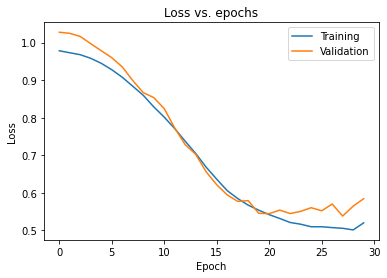

In [87]:
# Plot the training and validation loss

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

***
<a id="coding_tutorial_2"></a>
## Model regularisation

#### Adding regularisation with weight decay and dropout

In [ ]:
from tensorflow.keras.layers import Dropout
from tensorflow.keras import regularizers

In [ ]:
def get_regularised_model(wd, rate):
    model = Sequential([
        Dense(128, activation="relu", input_shape=(train_data.shape[1],)),
        Dense(128, activation="relu"),
        Dense(128, activation="relu"),
        Dense(128, activation="relu"),
        Dense(128, activation="relu"),
        Dense(128, activation="relu"),
        Dense(1)
    ])
    return model

In [ ]:
# Re-build the model with weight decay and dropout layers



In [ ]:
# Compile the model



In [ ]:
# Train the model, with some of the data reserved for validation



In [ ]:
# Evaluate the model on the test set



#### Plot the learning curves

In [ ]:
# Plot the training and validation loss

import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

***
<a id="coding_tutorial_3"></a>
## Introduction to callbacks

#### Example training callback

In [ ]:
# Write a custom callback



In [ ]:
# Re-build the model



In [ ]:
# Compile the model



#### Train the model with the callback

In [ ]:
# Train the model, with some of the data reserved for validation



In [ ]:
# Evaluate the model



In [ ]:
# Make predictions with the model



***
<a id="coding_tutorial_4"></a>
## Early stopping / patience

#### Re-train the models with early stopping

In [ ]:
# Re-train the unregularised model



In [ ]:
# Evaluate the model on the test set



In [ ]:
# Re-train the regularised model



In [ ]:
# Evaluate the model on the test set



#### Plot the learning curves

In [ ]:
# Plot the training and validation loss

import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12, 5))

fig.add_subplot(121)

plt.plot(unreg_history.history['loss'])
plt.plot(unreg_history.history['val_loss'])
plt.title('Unregularised model: loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')

fig.add_subplot(122)

plt.plot(reg_history.history['loss'])
plt.plot(reg_history.history['val_loss'])
plt.title('Regularised model: loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')

plt.show()